In [2]:
%precision 3

import numpy as np
import pandas as pd
from dtw import *
from matplotlib import pyplot as plt
from matplotlib import ticker
plt.style.use("minimal")

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [198]:
session = 1
datafile_path = f"data/Test{session}.tsv"

metadata_header_lines = 9

events = pd.read_csv(datafile_path, sep = "\t", header = None, names = ("Type", "Name", "Frame", "Time"), skiprows=metadata_header_lines, on_bad_lines = "skip").drop(columns = ["Type"])
events
print(f"""[INFO] found {1 + len(events[events["Name"] == "Trial"])} trials""")

data = pd.read_csv(datafile_path, sep = "\t", header = metadata_header_lines + len(events) + 2, usecols=lambda name: "Unnamed" not in name)

for frame, event_name in events.set_index("Frame")["Name"].items():
    data.loc[data["Frame"] == frame, "Event"] = event_name

data.insert(2, "Trial", ((data["Event"] == "Trial") & (data["Event"].fillna(0) != data["Event"].fillna(0).shift())).cumsum() + 1)

position_cols = [col for col in data.columns if col not in ["Frame", "Time", "Event", "Trial"]]
data[position_cols] = data[position_cols].replace(0, np.nan)
data[["Interp_" + col for col in position_cols]] = data[position_cols].replace(0, np.nan).interpolate()

data

In [218]:
# session = 1
# datafile_path = f"data/Test{session}.tsv"

# metadata_header_lines = 9

# events = pd.read_csv(datafile_path, sep = "\t", header = None, names = ("Type", "Name", "Frame", "Time"), skiprows=metadata_header_lines, on_bad_lines = "skip").drop(columns = ["Type"])
# events
# print(f"""[INFO] found {1 + len(events[events["Name"] == "Trial"])} trials""")

# marker_names = [marker[2:] for marker in pd.read_csv(datafile_path, sep = "\t", header = None, skiprows=metadata_header_lines + len(events), nrows = 1).loc[0][1:].values] 
# markers = sorted(set(marker_names))
# print(f"""[INFO] found markers: {", ".join(markers)}""")

# data = pd.read_csv(datafile_path, sep = "\t", header = metadata_header_lines + len(events) + 2, usecols=lambda name: "Unnamed" not in name).set_index("Time")

# def to_multiindex(data):
#     data.columns = data.columns.str.split("_", expand = True)
#     data = data.stack(0)
#     data.columns = data.columns.str.split(" ", expand = True)
#     data = data.stack(0)
#     data.index.set_names(("Time", "Participant", "Marker"), inplace = True)
#     return data

# data = to_multiindex(data)

# for frame, event_name in events.set_index("Time")["Name"].items():
#     data.loc[data.index.get_level_values("Time") == frame, "Event"] = event_name

# # data = data.droplevel("Frame")

# data["Trial"] = ((data["Event"] == "Trial") & (data["Event"].fillna(0) != data["Event"].fillna(0).shift())).cumsum() + 1
# data = data.set_index(["Trial", data.index]).drop(columns="Event")

# data = data.replace(0, np.nan)
# data[["Interp_" + col for col in data.columns]] = data.interpolate()

# data[data.index.get_level_values("Time") < 6.4]
# data

[INFO] found 1 trials
[INFO] found markers: Biceps, Elbow, Hand, HandLower, HandUpper, ShoulderRight, Thumb, Wrist, WristLower, WristUpper


X        Y         Z  Interp_X  \
Trial Time    Participant Marker                                                
1     6.07000 A           Biceps        -600.002 -242.194  1181.553  -600.002   
                          Elbow         -582.345 -259.206  1095.870  -582.345   
                          Hand          -430.113 -273.437   798.355  -430.113   
                          HandLower     -473.071 -258.293   767.601  -473.071   
                          HandUpper     -376.270 -245.656   782.839  -376.270   
...                                          ...      ...       ...       ...   
      6.39667 A           WristLower    -460.303 -262.693   844.176  -460.303   
                          WristUpper    -392.472 -242.723   841.202  -392.472   
              B           Elbow          537.854  161.792  1094.799   537.854   
                          Hand           413.065  191.205   827.721   413.065   
                          ShoulderRight  526.713  196.379  1261.684   526.713   

                                         Interp_Y  Interp_Z  
Trial Time    Participant Marker                             
1     6.07000 A           Biceps         -242.194  1181.553  
                          Elbow          -259.206  1095.870  
                          Hand           -273.437   798.355  
                          HandLower      -258.293   767.601  
                          HandUpper      -245.656   782.839  
...                                           ...       ...  
      6.39667 A           WristLower     -262.693   844.176  
                          WristUpper     -242.723   841.202  
              B           Elbow           161.792  1094.799  
                          Hand            191.205   827.721  
                          ShoulderRight   196.379  1261.684  

[1287 rows x 6 columns]

KeyError: 'Time'

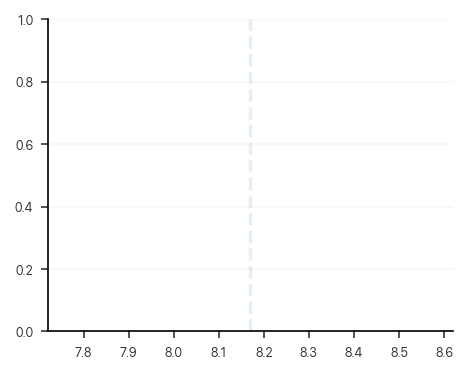

In [219]:
def plot_position(marker, axis):
    plt.figure()
    for time_of_hand_contact in events[events["Name"] == "Contact"]["Time"]:
        plt.axvline(time_of_hand_contact, linestyle = "--", alpha = 0.1, zorder = -1)
    plt.plot(data["Time"], (-1 if axis == "X" else 1) * data[f"A_{marker} {axis}"], linewidth = 1.2, label = "A", color = "C0")
    plt.plot(data["Time"], (-1 if axis == "X" else 1) * data[f"Interp_A_{marker} {axis}"], linewidth = 1.2, linestyle = ":", color = "C0")
    plt.plot(data["Time"], data[f"B_{marker} {axis}"], linewidth = 1.2, label = "B", color = "C1")
    plt.plot(data["Time"], data[f"Interp_B_{marker} {axis}"], linewidth = 1.2, linestyle = ":", color = "C1")
    plt.margins(x = 0, y = 0)
    plt.title(f"Position {axis} - {marker}\n")
    plt.xlabel("Time (sec)")
    plt.ylabel(f"{axis} position")
    plt.legend(loc = "upper right")
    plt.tight_layout()

plot_position(marker = "Elbow", axis = "X")
# plot_position(marker = "Elbow", axis = "Z")

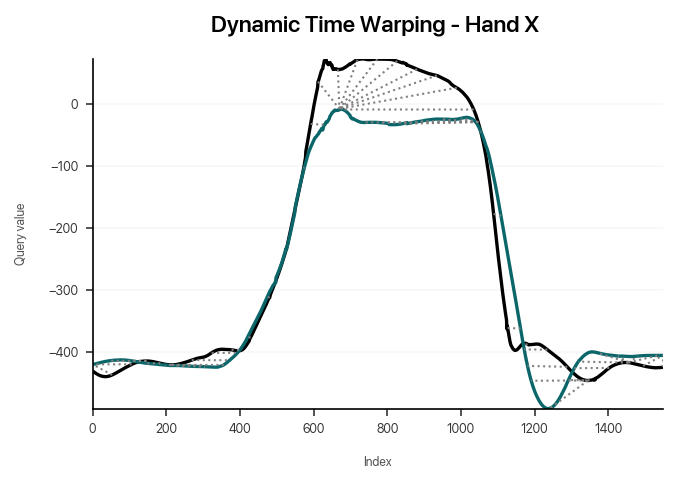

In [37]:
subset = data[data["Time"].between(22, 23)]
subset = data

def plot_dtw(marker, axis):
    dtw(subset[f"Interp_A_{marker} {axis}"].values, -subset[f"Interp_B_{marker} {axis}"].values, keep_internals=True).plot(type = "twoway")
    plt.margins(x = 0, y = 0)
    plt.title(f"Dynamic Time Warping - {marker} {axis} \n")
    plt.tight_layout()

plot_dtw(marker = "Hand", axis = "X")

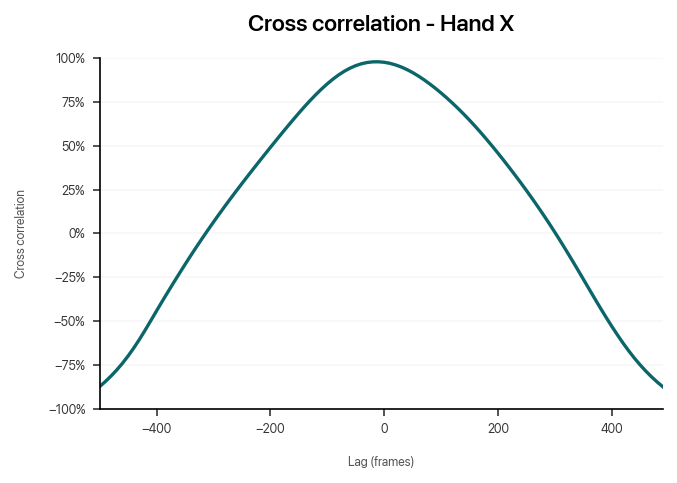

In [6]:
subset = data[data["Time"].between(22, 23)]
subset = data

def plot_cross_correlation(marker, axis, lags = np.arange(-500, 500, 10)):
    cross_corrs = [subset[f"Interp_A_{marker} {axis}"].corr((-1 if axis == "X" else 1) * subset[f"Interp_B_{marker} {axis}"].shift(lag)) for lag in lags]
    plt.plot(lags, cross_corrs)
    plt.xlabel("Lag (frames)")
    plt.ylabel("Cross correlation")
    plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(1))
    plt.title(f"Cross correlation - {marker} {axis}\n")
    plt.margins(x = 0, y = 0.1)
    plt.ylim((-1, 1))
    plt.tight_layout()

plot_cross_correlation("Hand", "X")

          Time  A_ShoulderRight X  A_ShoulderRight Y  A_ShoulderRight Z  \
0      6.07000           -551.638           -299.897           1380.828   
1      6.07333           -551.680           -299.847           1380.756   
2      6.07667           -551.719           -299.791           1380.682   
3      6.08000           -551.754           -299.742           1380.611   
4      6.08333           -551.766           -299.671           1380.542   
...        ...                ...                ...                ...   
1545  11.22000           -563.093           -300.856           1375.846   
1546  11.22333           -563.044           -300.888           1375.831   
1547  11.22667           -562.989           -300.874           1375.839   
1548  11.23000           -562.956           -300.879           1375.827   
1549  11.23333           -562.892           -300.865           1375.810   

      A_Elbow X  A_Elbow Y  A_Elbow Z  A_Hand X  A_Hand Y  A_Hand Z  
0      -582.345   -259.206   

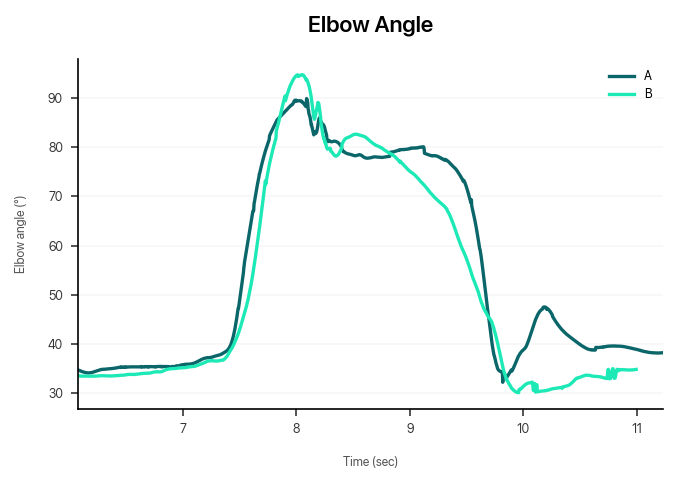

In [35]:
def calc_angles(data, participant, markers):
    data.loc[:, ["dX1", "dY1", "dZ1"]] = data[[f"{participant}_{markers[0]} {axis}" for axis in "XYZ"]].values - data[[f"{participant}_{markers[1]} {axis}" for axis in "XYZ"]].values
    data.loc[:, ["dX2", "dY2", "dZ2"]] = data[[f"{participant}_{markers[1]} {axis}" for axis in "XYZ"]].values - data[[f"{participant}_{markers[2]} {axis}" for axis in "XYZ"]].values
    line1 = data[["dX1", "dY1", "dZ1"]].divide(np.linalg.norm(data[["dX1", "dY1", "dZ1"]].values, axis=1), axis = 0)
    line2 = data[["dX2", "dY2", "dZ2"]].divide(np.linalg.norm(data[["dX2", "dY2", "dZ2"]].values, axis=1), axis = 0)

    return np.degrees(np.arccos(np.clip(np.sum(line1.values * line2.values, axis = 1), -1, 1)))

def plot_angles(markers):
    for participant in "AB":
        subset = data[["Time"] + [f"{participant}_{marker} {axis}" for marker in markers for axis in "XYZ"]].dropna()
        print(subset)
        plt.plot(subset["Time"], calc_angles(subset, participant, markers), label = participant)
    plt.title("Elbow Angle\n")
    plt.xlabel("Time (sec)")
    plt.ylabel("Elbow angle (°)")
    plt.margins(x=0)
    plt.legend()
    plt.tight_layout()

plot_angles(("ShoulderRight", "Elbow", "Hand"))

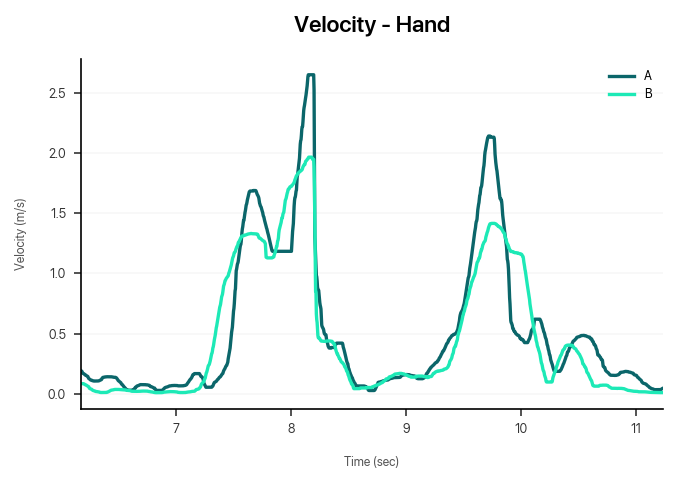

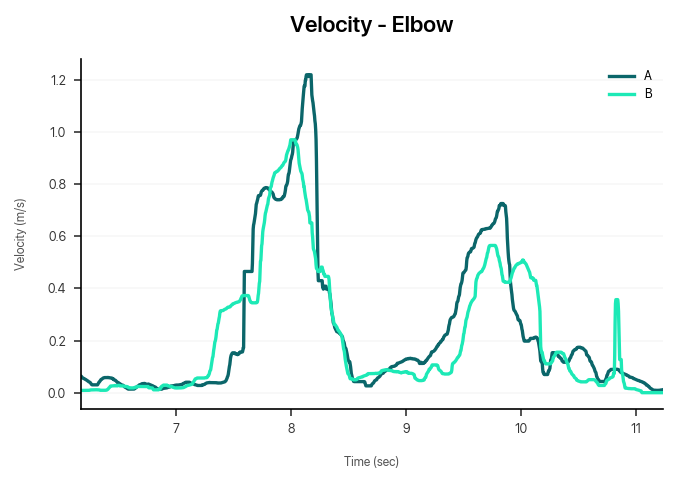

In [48]:
def calculate_velocity(data, participant, marker):
    data.loc[:, ["dX", "dY", "dZ"]] = data[[f"Interp_{participant}_{marker} {axis}" for axis in "XYZ"]].values - data[[f"Interp_{participant}_{marker} {axis}" for axis in "XYZ"]].shift(1).values
    data["d"] = data[["dX", "dY", "dZ"]].apply(lambda vals: np.sqrt(vals["dX"]**2 + vals["dY"]**2 + vals["dZ"]**2), axis = 1)
    data["d"] = data["d"].rolling(30).median()
    return (data["d"] * 300) / 1000 # unit m/s

def plot_velocity(marker):
    plt.figure()
    for participant in "AB":
        subset = data[["Time"] + [f"Interp_{participant}_{marker} {axis}" for axis in "XYZ"]].dropna()
        plt.plot(subset["Time"], calculate_velocity(subset, participant, marker), label = participant)
    plt.title(f"Velocity - {marker}\n")
    plt.xlabel("Time (sec)")
    plt.ylabel("Velocity (m/s)")
    plt.margins(x=0)
    plt.legend()
    plt.tight_layout()

plot_velocity("Hand")
plot_velocity("Elbow")